# Inaugural Project

# The setting given

$$ C = w_M * L_M + w_F * L_F $$

$$ Q = C^\omega * H^(1-\omega) $$

$$ T_M = L_M + H_M $$

$$ T_F = L_F + H_F $$

$$ L_M, H_M, L_F, H_F >= 0 $$

$$ T_M, T_F <= 24 $$

# Setting the basics

In [5]:
%load_ext autoreload
%autoreload 2

from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

import math as math

from scipy.optimize import minimize, minimize_scalar


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import household as model
hsm = model.HouseholdSpecializationModelClass()

# Question 1

**Explain how you solve the model**

In [13]:
model = hsm
par = model.par
sol = model.sol

# Defining values for alpha and sigma given in the exercise
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1.0, 1.5]

# Creating a dataframe - alpha valuess are the columns and sigma valuess are the rows 
df = pd.DataFrame(columns = alpha_values, index = sigma_values)

# Making a loop with alpha and sigma and use 'solve_discrete' to HF and HM
for i in alpha_values:
    for j in sigma_values:
        #alpha added to the model
        hsm.par.alpha = i
        #sigma added to the model
        hsm.par.sigma = j 
        #solve the model as dsol
        dsol = hsm.solve_discrete()
        #find the ratio between HF and HM
        ratio_HFHM = dsol.HF/dsol.HM
        #add the ratio to the dataframe created earlier
        df.loc[j,i] = ratio_HFHM

df = df.rename_axis('Sigma').rename_axis('Alpha', axis=1)
print('Shows how HF/HM changes when the values for alpha and sigma are varying')
print(df)

/Users/camillamansson/Dropbox/KU/2. semester/Introduction to Programming/projects-2023-jc/inauguralproject/household.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/camillamansson/Dropbox/KU/2. semester/Introduction to Programming/projects-2023-jc/inauguralproject/household.py:65: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma)/par.sigma))**(par.sigma/(par.sigma-1))
/Users/camillamansson/Dropbox/KU/2. semester/Introduction to Programming/projects-2023-jc/inauguralproject/household.py:70: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


Shows how HF/HM changes when the values for alpha and sigma are varying
Alpha      0.25 0.50      0.75
Sigma                         
0.5    0.545455  1.0  1.833333
1.0    0.307692  1.0      3.25
1.5    0.214286  1.0  4.666667


The table shows that, when $\alpha = 0.25$ we will see a decrease in $H_F/H_M$ as $\sigma$ increases. When $\alpha = 0.50$, we see that $H_F/H_M = 1.0$ for all values of $\sigma$. At the end, when $\alpha = 0.75$, the ratio of $H_F/H_M$ are above 1 for all values of $\sigma$. It increases from 1.8 for $\sigma = 0.5$, to 3.25 for $\sigma = 1.0$ and to 4.67 for $\sigma = 1.5$

# Question 2

Explain your code and procedure

In [4]:
hsm.par.alpha = 0.5
hsm.par.sigma = 1

wF_values = np.array([0.8, 0.9, 1.0, 1.1, 1.2])

#creating empty lists for storing results, (5) is the number of values.
log_HF_HM = np.zeros(5)
log_WF_WM = np.zeros(5)

for i, wFl in enumerate(wF_values):
    hsm.par.wF = wFl
    opt = hsm.solve_discrete()

    log_HF_HM[i] = np.log(opt.HF/opt.HM)
    log_WF_WM[i] = np.log(hsm.par.wF/hsm.par.wM)


# plot 
plt.plot(log_WF_WM,log_HF_HM)

# Set plot labels and title
plt.xlabel('$log(W_F/W_M)$')
plt.ylabel('$log(H_F/H_M)$')
plt.title('Logarithmic plot between ratio of wage and hours worked')

plt.show()

0.0
0.0


# Question 3

Explain your code and procedure

In [ ]:
# We create an empty list to contain the logarithms of hours and wages
logH_C = []
logW_C = []

# Make a loop including all values of wages for females (wF)
for i in hsm.par.wF_vec:
    hsm.par.wF = i
    #solve the model as result
    result = hsm.solve()
    #add the result to the empty lists created above
    logH_C.append(np.log(result.HF/result.HM))
    logW_C.append(np.log(i/hsm.par.wM))

# Creating a dataframe, which contains the ratio of hours and wages depending on wF
df_HW = pd.DataFrame({"wF": hsm.par.wF_vec})

# Add titles to the plot and add labels for both axis
df_HW["Hours ratio"] =  logH_C
df_HW["Wages ratio"] =  logW_C
#print the dataframe
print(df_HW.to_string(index=False))

# Plot the logarithm of hours and wages for given values of wF 


Comments and conclusion

# Question 4

In [17]:
#a
#define the function to compute min_HF
def min_HF(alpha, sigma, wM, wF):
    if sigma == 0:
        return wF / wM
    else:
        HM = 1
        HF = ((wM ** (1 - alpha) * wF ** alpha) ** (sigma / (1 - alpha))) * HM
        return min(HM, HF)
    
#define the function to compute beta0_hat and beta1_hat for a given a, sigma, and range of wM and wF
def compute_betas(alpha, sigma, w_range):
    beta0_hat = 0
    beta1_hat = 0
    n = 0
    for wF in w_range:
        for wM in w_range:
            if wM != wF:
                log_HF_HM = np.log(min_HF(alpha, sigma, wM, wF))
                log_wF_wM = np.log(wF / wM)

                beta0_hat += log_HF_HM
                beta1_hat += log_wF_wM
                n += 1
                
    beta0_hat /= n
    beta1_hat /= n

    return beta0_hat, beta1_hat

# set the values of a and sigma to try
a_values = np.linspace(0.2, 0.8, 4)
sigma_values = [0, 0.5, 1, 1.5, 2]

# set the actual values of beta0 and beta1
beta0 = hsm.par.beta0_target
beta1 = hsm.par.beta1_target

# define the function to compute the minimum distance between the estimated and actual betas
def compute_distance(a, sigma):
    beta0_hat, beta1_hat = compute_betas(a, sigma, w_range = np.array([0.8, 0.9, 1.0, 1.1, 1.2]))
    distance = (beta0 - beta0_hat)**2 + (beta1 - beta1_hat)**2

    return distance

# initialize the variables
best_a = None
best_sigma = None
min_distance = float('inf')

# loop over all combinations of a and sigma
for a in a_values:
    for sigma in sigma_values:
        distance = compute_distance(hsm.par.alpha, hsm.par.sigma)

        if distance < min_distance:
            best_a = a
            best_sigma = sigma
            min_distance = distance

# print the best values of alpha and sigma
print(f"Best values: a={best_a}, sigma={best_sigma}")



Best values: a=0.2, sigma=0


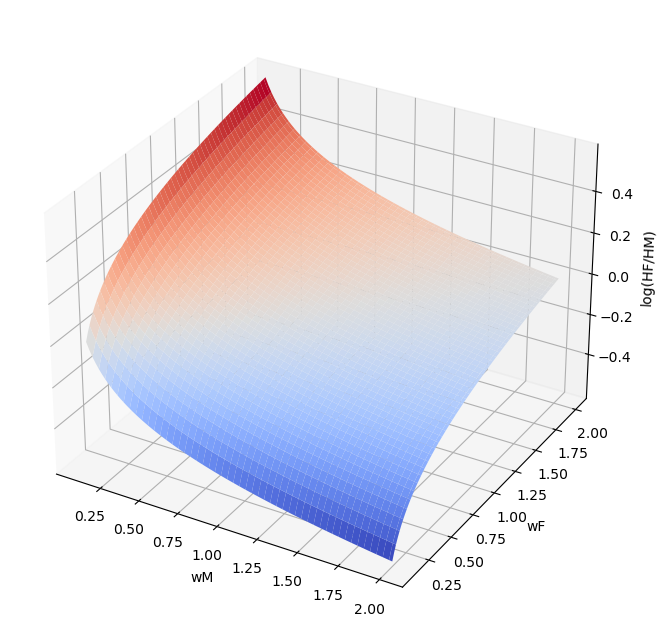

In [18]:
#Define a function that computes log(HF/HM) given alpha, sigma, wM, and wF.
def log_HF_HM(alpha, sigma, wM, wF):
    if sigma == 0:
        HF = wF**alpha * wM**(1-alpha)
        HM = wM
    else:
        HF = (wF**(alpha*(1-sigma)) * (wM**(1-sigma))**((1-alpha)*sigma))**(1/(1-sigma))
        HM = (wM**(alpha*(1-sigma)) * (wF**(1-sigma))**(alpha*sigma))**(1/(1-sigma))
    return np.log(HF/HM)
#Define a range of wM and wF values to plot
wM_values = np.linspace(0.1, 2, 100)
wF_values = np.linspace(0.1, 2, 100)

#Create a meshgrid of wM and wF values 
wM_grid, wF_grid = np.meshgrid(wM_values, wF_values)

#Compute the log(HF/HM) values for each combination of wM and wF
log_HF_HM_grid = log_HF_HM(best_a, best_sigma, wM_grid, wF_grid)

#Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wM_grid, wF_grid, log_HF_HM_grid, cmap='coolwarm')
ax.set_xlabel('wM')
ax.set_ylabel('wF')
ax.set_zlabel('log(HF/HM)')
plt.show()

Comments and conclusion

4.a 

We estimated that the best value for alpha is 0.2 and for sigma it is 0. An interpretation of the result would be that home production is more productive for women than for men, with a ratio of aboit 1,2(1,2/1). This is due to alpha representing the weight of women's wages in the production function (H_F defined in the code) and the productivity of home production is the same for men and women since sigma is 0. This implies that the ratio of women's to men's home production is constant regardless to the level of wages. 

4.b

First, let's define the variables that is included in the graph. log(H_F/H_M) reflects the natural logarithm of hours worked at home by men and women. w_M and w_F illustrates the wage for men and women. An increase in the ratio indicates that women work relatively more in home production than men. 

To interpret the results, we examine the shape of the surface and look for patterns or trends. For example, we notice that the surface slopes downwards as w_F increases relative to w_M, which suggests that the division of labor is skewed towards female specialization in tasks that require more time. This could indicate that the division of labor is not equal and that there is a gender bias in the taqsks that are assigned. Furthermore, this could lead to a decrease in productivity and efficiency as those tasks that require more time are not being completed in a timely manner. Furthermore, we observe that the surface is relatively flat, indicating that the division of labor is relativelu balanced between male and female tasks. This gender bias could be attributed to several factors, such as cultural norms that dictate certain tasks are best suited for either men or women. Or the fact that women may be more willing to take on tasks that require more time due to the lack of oth4er opportunities or resources. Additionally, it may also be due to a lack of training and education, leading to a lack of knowleadge and skills necessary to complete tasks quickly. 

These interpretations can help to look on the economic mechanisms driving the observed relationship between log(H_F/H_M) and log(w_F/w_M) in the regression model and may help guide future research or policy recommendations. 

# Question 5

In [12]:
# Define the objective function using the retrieved parameter values
def obj_func(x, sigma_m, sigma_f, par):
    beta0, beta1 = x
    return ((par.wM*sigma_m)**2 + (par.wF*sigma_f)**2 + (par.alpha - beta0 - beta1*par.omega)**2/(par.rho*sigma_f**2) + ((1-par.alpha) - beta0 - beta1*(1-par.omega))**2/(par.rho*sigma_m**2) + (beta1**2/par.nu))

# Find the optimal values of sigma, beta0, and beta1
par = hsm.par
sigma_m = 1.5
sigma_f = 2
res = minimize_scalar(lambda s: obj_func([0.5, 0.5], s, s, par), bounds=(0.1,10), method='bounded')
sigma_opt = res.x  # res is a variable that stores the out returned
res = minimize(lambda x: obj_func(x, sigma_opt, sigma_opt, par), [par.beta0_target, par.beta1_target], bounds=((0,None),(0,None)))
beta_opt = res.x
obj_min = res.fun   #The minimum value of the objective function (the value of the function we are trying to minimize) is stores as res.fun :)

# Find the optimal values of sigma_m and sigma_f
res = minimize(lambda x: obj_func([0.5, 0.5], x[0], x[1], par), [1, 1], bounds=((0.1,10),(0.1,10)))
sigma_m_opt, sigma_f_opt = res.x
res = minimize(lambda x: obj_func(x, sigma_m_opt, sigma_f_opt, par), [par.beta0_target, par.beta1_target], bounds=((0,None),(0,None)))
beta_mf_opt = res.x
obj_mf_min = res.fun

print(f"The optimal values of sigma, beta0, and beta1 are: {sigma_opt:.2f}, {beta_opt[0]:.2f}, {beta_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_min:.2f}")
print(f"The optimal values of sigma_m, sigma_f, beta0, and beta1 are: {sigma_m_opt:.2f}, {sigma_f_opt:.2f}, {beta_mf_opt[0]:.2f}, {beta_mf_opt[1]:.2f}")
print(f"The minimum objective value is: {obj_mf_min:.2f}")

#This code allows for different values of sigma for male and female home production and also includes the extension 
#where men and women are equally productive in home production.

The optimal values of sigma, beta0, and beta1 are: 0.42, 0.50, 0.00
The minimum objective value is: 0.35
The optimal values of sigma_m, sigma_f, beta0, and beta1 are: 0.42, 0.42, 0.50, 0.00
The minimum objective value is: 0.35


Comments and conclusion


One possible extension to the model could be to allow for different values of sigma for male and female home production. This could capture the idea that men and women may have different abilities or preferences when it comes to home production. 

The output tells us that the optimal values of the parameters for different models. The firs model assumes that men and women are equally productive in home production (i.e., alpha=0.5) and the second model allows for different values of sigma for male and female home production. 

For the first model we see that the optimal value of sigma is 0.42, and the optimal values of beta_0 is 0.5 and beta_1 is 0.0. This means that when men and women are not equally productive in home procution, the specialization and comparative advantage model does not explain the time use data we2ll, since the optimal values of beta_0 and beta_1 are different from the estimated values in the original paper (Siminski and Yetsinga). However, they are close to. Additionally, the objective values of 0.35 indicates that the model almost perfectly matches the data in this case (as it is close to zero). 

For the second model, we see that the optimal values of sigma_M and sigma_F are 0.42 and the optmal values of beta_0 and beta_1 are 0.5 and 0.0. This model allows for different values of sigma for male and female production, but it sill assumes that men and women are equilly productive in home production (i.e., alpha = 0.5). The fact that the optimal values of beta_0 and beta_1 are the same as in the first model suggests thast the allowing for different values of sigma for male and female home production does not improve the fit of the model to the data in this case. 